Create a RAG app with the following structure

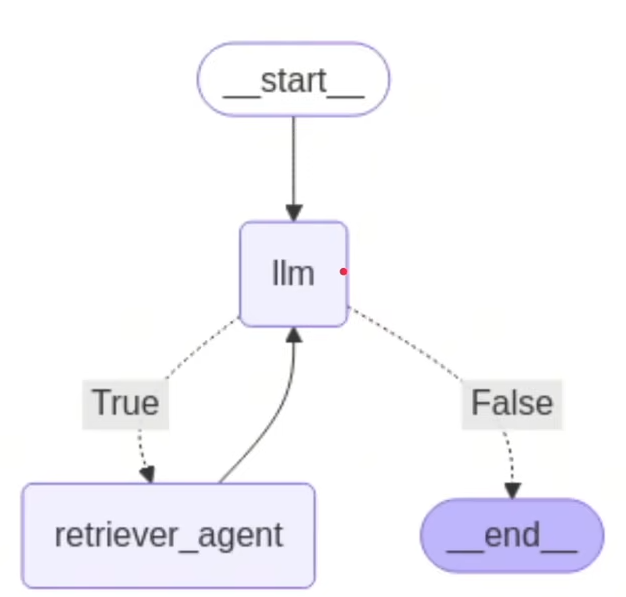

In [37]:
from IPython.display import Image, display

display(Image(filename='imgs/05_agent.png'))

In [38]:
from dotenv import load_dotenv
import os
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage
from operator import add as add_messages
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
# from langchain_chroma import Chroma
from langchain_core.tools import tool


In [39]:
from langchain_google_genai import ChatGoogleGenerativeAI


from dotenv import load_dotenv
import os
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_GENAI_API_TOKEN")

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",  
    temperature=0,
    google_api_key=GOOGLE_API_KEY)

In [40]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004", google_api_key=GOOGLE_API_KEY)
# vector = embeddings.embed_query("hello, world!")
# vector[:5]

In [41]:
from langchain_community.document_loaders import PyPDFLoader

pdf_load = PyPDFLoader("docs/Stock_Market_Performance_2024.pdf")

In [42]:
try:
    pages = pdf_load.load()
    print(f"PDF has been loaded and has {len(pages)} pages")
except Exception as e:
    print(f"Error loading PDF: {e}")
    raise



PDF has been loaded and has 9 pages


In [43]:
# chunk step

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 200
    
)

In [44]:
pages_split = text_splitter.split_documents(pages)

db_path = os.getenv("CHROMA_DB_PATH")
db_name = os.getenv("COLLECTION_NAME")

if not os.path.exists(db_path):
    os.makedirs(db_path)

    

In [45]:
from langchain.vectorstores import Chroma
try:
    # Here, we actually create the chroma database using our embeddigns model
    vectorstore = Chroma.from_documents(
        documents=pages_split,
        embedding=embeddings,
        persist_directory=db_path,
        collection_name=db_name
    )
    print(f"Created ChromaDB vector store!")
    
except Exception as e:
    print(f"Error setting up ChromaDB: {str(e)}")
    raise

Created ChromaDB vector store!


In [46]:
# retriever

retriever = vectorstore.as_retriever(
    search_type = "similarity",
    search_kwargs = {"k": 5} #k is the amount of chunks to return
)

In [47]:
# docs = retriever.invoke("S&P 500 performance in 2024")
# print("Retrieved:", len(docs))
# for d in docs:
#     print(d.page_content[:100])


In [48]:
@tool
def retriever_tool(query: str) -> str:
    """
    This tool searches and returns the information from the Stock Market Performance 2024 document.
    """

    docs = retriever.invoke(query)

    if not docs:
        return "I found no relevant information in the Stock Market Performance 2024 document."
    
    results = []
    for i, doc in enumerate(docs):
        results.append(f"Document {i+1}:\n{doc.page_content}")
    
    return "\n\n".join(results)

In [49]:
# results = retriever.get_relevant_documents("S&P 500 performance in 2024")
# print(f"Number of results: {len(results)}")
# for r in results:
#     print(r.page_content)


In [50]:
tools = [retriever_tool]

llm = llm.bind_tools(tools) # the agent "learns" that it has tools to use

In [51]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [52]:
# if it does contain tools it will continue, if there is no tools it ends

def should_continue(state:AgentState):
    """ 
    Check if the last message contains tool calls
    """

    result = state["messages"][-1]
    return hasattr(result, "tool_calls") and len(result.tool_calls) > 0

In [53]:
# define the prompt so the LLM knows explicitly that it has tools to use
# ask for reference of the documentation for lesser hallucinations

system_prompt = """
You are an intelligent AI assistant who answers questions about Stock Market Performance in 2024 based on the PDF document loaded into your knowledge base.
Use the retriever tool available to answer questions about the stock market performance data. You can make multiple calls if needed.
If you need to look up some information before asking a follow up question, you are allowed to do that!
Please always cite the specific parts of the documents you use in your answers.
"""

In [54]:
# create dict of our tools
tools_dict = {our_tool.name: our_tool for our_tool in tools}

In [55]:
def call_llm(state: AgentState) -> AgentState:
    """Function to call the LLM with the current state."""
    messages = list(state['messages'])
    messages = [SystemMessage(content=system_prompt)] + messages
    message = llm.invoke(messages)

    print("\n--- LLM RESPONSE ---")
    print(message)
    print("--- END RESPONSE ---\n")

    return {'messages': [message]}


In [56]:

# Retriever Agent
def take_action(state: AgentState) -> AgentState:
    """Execute tool calls from the LLM's response."""

    tool_calls = state['messages'][-1].tool_calls # check the tools in the last message
    results = []
    for tool_call in tool_calls:
        print(f"Calling Tool: {tool_call['name']} with query: {tool_call['args'].get('query', 'No query provided')}")
        
        if not tool_call['name'] in tools_dict: # Checks if a valid tool is present
            print(f"\nTool: {tool_call['name']} does not exist.")
            result = "Incorrect Tool Name, Please Retry and Select tool from List of Available tools."
        
        else:
            result = tools_dict[tool_call['name']].invoke(tool_call['args'].get('query', ''))
            print(f"Result length: {len(str(result))}")
            

        # Appends the Tool Message
        results.append(ToolMessage(tool_call_id=tool_call['id'], name=tool_call['name'], content=str(result)))

    print("Tools Execution Complete. Back to the model!")
    return {'messages': results}


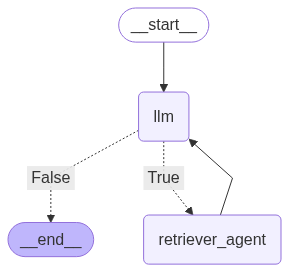

In [57]:
graph = StateGraph(AgentState)
graph.add_node("llm", call_llm)
graph.add_node("retriever_agent", take_action)

graph.add_conditional_edges(
    "llm",
    should_continue,
    {True: "retriever_agent", False: END}
)
graph.add_edge("retriever_agent", "llm")
graph.set_entry_point("llm")

rag_agent = graph.compile()

from IPython.display import Image, display
display(Image(rag_agent.get_graph().draw_mermaid_png()))

In [58]:
def running_agent():
    print("\n=== RAG AGENT===")
    
    while True:
        user_input = input("\nWhat is your question: ")
        if user_input.lower() in ['exit', 'quit']:
            break
            
        messages = [HumanMessage(content=user_input)] # converts back to a HumanMessage type

        result = rag_agent.invoke({"messages": messages})
        
        print("\n=== ANSWER ===")
        print(result['messages'][-1].content)


In [59]:
running_agent()


=== RAG AGENT===

--- LLM RESPONSE ---
content='' additional_kwargs={'function_call': {'name': 'retriever_tool', 'arguments': '{"query": "s&p performance in 2024"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run--899f60b5-91c8-4556-990c-eb9a39a10466-0' tool_calls=[{'name': 'retriever_tool', 'args': {'query': 's&p performance in 2024'}, 'id': 'bbec6801-3f7c-4475-8dbf-b598f4af03bd', 'type': 'tool_call'}] usage_metadata={'input_tokens': 132, 'output_tokens': 15, 'total_tokens': 147, 'input_token_details': {'cache_read': 0}}
--- END RESPONSE ---

Calling Tool: retriever_tool with query: s&p performance in 2024
Result length: 4818
Tools Execution Complete. Back to the model!

--- LLM RESPONSE ---
content='The S&P 500 delivered roughly a 25% total return for 2024 (around +23% in price terms). This was the second consecutive year of over 20% returns for the S&P 500, a 